# Ch 2. Agents
Artificial Intelligence: Foundations of Computational Agents (AIFCA) chapter 2.   
Python Code for Artificial Intelligence (PCAI) chapter 2.   
Use the agent*.py scripts.   

In [14]:
import sys
import os
print(sys.version)

3.12.5 (v3.12.5:ff3bc82f7c9, Aug  7 2024, 05:32:06) [Clang 13.0.0 (clang-1300.0.29.30)]


In [15]:
# Relative path to the subdirectory containing textbook code samples.
AIPYTHONDIR='modified'  # contains the textbook's 'aipython' code with the instructor's modifications 
# Tell python to look here first.
sys.path.insert(0, AIPYTHONDIR)

## Code Changes for 2.1
The aipython code is written to be imported from the command line. The instructor changed a few lines to make the code more useful as a module for notebooks. Originally, 3 global variables declared and initialized automatically when the module was imported. Now they can be intialized in notebooks after importing the module.

Create agentGlobal.py to declare global variables

    # Declare three globals
    global evn
    global ag
    global sim

Change agentBuying.py to remove its global variables

    # Comment out these global variable declarations
    #env = TP_env()
    #ag = TP_agent()
    #sim = Simulate(ag,env)


Change agentBuying.py to add our global variables

    # Put this near the top
    import agentGlobal as globals

    # Add this to the start of TP_agent.__init__()
    env = globals.env

    # Add this to the start of Plot_history.__init__()
    self.ag = ag
    self.env = env

    # Add this to the start of Plot_history.plot_env_hist()
    env = self.env

    # Add this to the start of Plot_history.plot_agent_hist()
    ag = self.ag

## Code Changes for 2.2
The aipython code was written to run from the command line, and it opens a stand-alone display window with matplotlib. The instructor changed a few lines to make the code more useful within notebooks. Now the Python code can continually update a display inside a notebook cell.

Change agentEnv.py to us the IPython display module for matplotlib commands. 

    # Just above class World, add this import
    from IPython import display as ddd

    # Int the World constructor, change fig from local variable to instance variable, and set a Boolean flag
    self.fig, self.ax = plt.subplots()
    self.ipython = False

    # Add this method to class World reset the Boolean flag
    def set_ipython(self):
        self.display_handle = ddd.display(self.fig,display_id=True)  
        self.ipython = self.display_handle is not None

    # Change the end of World.do() so it checks the Boolean flag
    if self.ipython:
        self.display_handle.update(self.fig)  # similar to draw(), show(), and pause()
        time.sleep(self.sleep_time)
    else:
        plt.draw()
        plt.pause(self.sleep_time)
    return {'walls':self.walls}

## 2.1 Agent and Environment

Build an agent for keeping the home stocked with toilet paper. See AIFCA 2.1 and PCAI chapter 2.2.

Percepts at time t: amount in stock at home, current price at the store.
Commands at time t: amount to purchase (usually zero).
Logic: buy 48 if the current price is below average and stock<60, or buy 12 if stock<12, or do nothing.

In [16]:
from agentBuying import TP_env, TP_agent, Simulate, Plot_history
import agentGlobal as globals
globals.env = TP_env()
globals.ag = TP_agent() # TP_agent(env)
globals.sim = Simulate(globals.ag,globals.env)
TIMEPERIODS=90

In [17]:
globals.sim.go(TIMEPERIODS)
print(f"agent spent ${globals.ag.spent/globals.env.time}")

agent spent $677.2


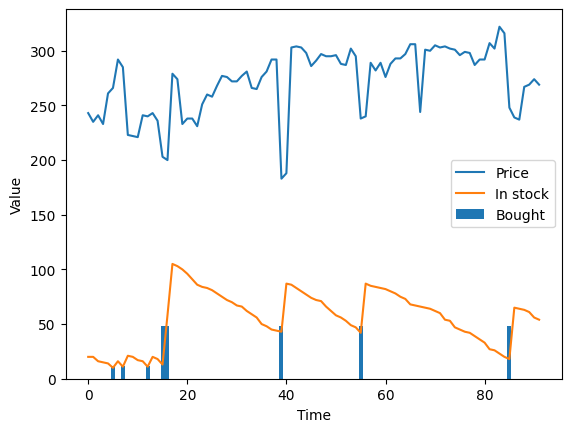

In [18]:
pl = Plot_history(globals.ag,globals.env)
pl.plot_env_hist() # pl.plot_env_hist(env)
pl.plot_agent_hist() # pl.plot_agent_hist(ag)

What is in the plot?
1. Agent continually using paper and buying more whenever inventory gets low. 
2. Due to randomness, the simulation changes every time you run the code.
3. Blue wiggle: price starts at $234 then fluctuates according to randomness and (hard coded array of) price deltas.
4. Orange wiggle: the amount of paper in inventory, following a (hard coded dictionary of) usage pattern.
5. Vertical bar: the size of a purchase.

### Thought Questions
1. Describe this program using these vocabulary words: percept, command, transduction, controller, agent, model, belief state.
2. What sensors & actuators would be required to convert this program into a real world robot (and do away with those hard-coded arrays)?
3. List some things that could go wrong in the real world, where signal transduction involves latency and noise?
4. If our goal is never to run out of toilet paper, is this agent performant?
5. The agent seems to have a secondary goal of saving money. How would you score performance toward this goal?
6. The agent memory does not store the history of time:price pairs. So how does it compute the average recent price? Read the TP_agent code and refer to Example 2.3 in the textbook.

## 2.2 Hierarchial Control

Simulate a robot navigating a room with obstacles.
Build a multi-layer agent. 
See AIFCA 2.2 and PCAI chapter 2.3.

In [19]:
import display, agents, agentBuying, agentEnv, agentTop, agentMiddle
from agentEnv import line_segments_intersect

In [20]:
# Test cases:
assert line_segments_intersect( ((0,0),(1,1)), ((1,0),(0,1)) )
assert not line_segments_intersect( ((0,0),(1,1)), ((1,0),(0.6,0.4)) )
assert line_segments_intersect( ((0,0),(1,1)) ,((1,0),(0.4,0.6)) )

In [21]:
from agentEnv import Rob_body, World
from agentMiddle import Rob_middle_layer
from agentTop import Rob_top_layer # Plot_env

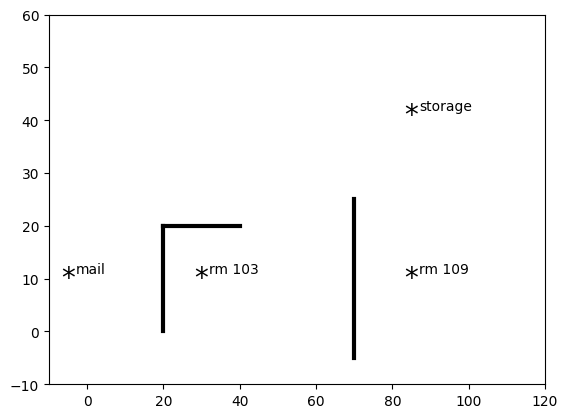

In [22]:
# Walls are immutable line segments.
# Rob_world is-a Displayable but that isn't used here.
# Rob_world acts as container for set of walls.
walls = { ((20,0),(20,20)), ((20,20),(40,20)), ((70,-5),(70,25))}
locations = {'mail':(-5,10), 'rm 103':(30,10), 'rm 109':(85,10),'storage':(85,41)} 
world = World(walls,locations)   # calls draw()

In [23]:
# Appears to do nothing because it is re-drawing the above.
world.draw()

Using the interactive Python REPL, these commands plot the robot going about its business. Don't type the '$' or '>' prompts. Both examples are also shown in the agentTop.py file.

    $ python
    > import agentTop as at
    > at.agentTop.rob_ex()
    > at.top.do({'visit':['o109','storage','o109','o103']})

### Robot simulation

In [24]:
# The robot has 3 parts: body, middle, top.
# Each parts is-a Environnment: do() takes one action and returns next percept.
# Body takes world of walls as first parameter.
# Body takes an optional second parameter for its initial position.
# The middle and top controllers will be parameterized later.
body = Rob_body(world) # do() moves one step, possibly interacts with wall
middle = Rob_middle_layer(body) # do () moves to its goal
top = Rob_top_layer(middle,world) # do() loops through its goals

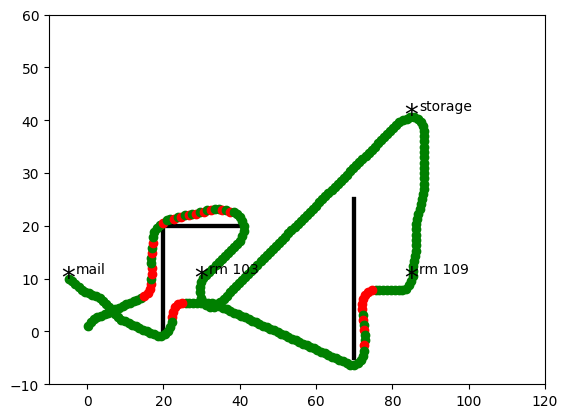

In [25]:
world.set_ipython()

In [26]:
# This should draw a trace in the notebook cell above
top.do({'visit':['rm 103','storage','rm 109','mail']})

Goal rm 103 {'arrived': True}
Goal storage {'arrived': True}
Goal rm 109 {'arrived': True}
Goal mail {'arrived': True}


The robot only detects a wall when the wall is in close proximity.    
The robot crashes if it cannot turn fast enough to avoid a wall collision.    
Try changing the robot's starting position or list of objectives or timeout.     
Then re-run the previous two cells to re-run the simulation.    
